<img src="img/bigsem.png" width="40%" align="right">
<img src="img/logo_wiwi.png" width="20%" align="left">





<br><br><br><br>

# Dynamic Programming Models in Combinatorial Optimization
**Winter Term 2024/25**


# 3a. Decision Diagrams

<img src="img/decision_analytics_logo.png" width="17%" align="right">


<br>

<br>
<br>

**J-Prof. Dr. Michael Römer |  Decision Analytics Group**
                                                    


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numba import njit, typeof
from typing import NamedTuple, Callable
from dataclasses import dataclass, field
from numba.experimental import jitclass
from IPython.display import SVG, display, clear_output

# Overview
- Decision Diagrams
- Exact Decision Diagrams
- Reducing Exact Decision Diagrams
- Restricted Decision Diagrams
- Branch and Bound based on Decision Diagrams

In [2]:
class DP(NamedTuple):
    feasible_decisions : Callable
    transition_function : Callable
    cost_function : Callable
    direction : str # 'max' or 'min'

#### States
- we are free to define our state representation
- for later purposes, it will be useful if the state variable is immutable, therefore tuples or namedtuple are useful data structures for states


#### Decisions
- in most cases in this part, we will assume that decisions are integers, but note that this is not required as long as the transition function works
- however, for now, we assume that decisions only induce a change between stages -- we will relax that requirement later in the course


#### Instance data
- all functions named above take an instance as parameter. Instance data does not have to take a certain form, it just needs to "match" the (problem-specific) functions

## Generic helper functions to deal with maximization and minimization

In [3]:
@njit 
def better(value1, value2, direction):
    if direction == "min":
        
        return value1 < value2
    else:
        return value1 > value2

In [4]:
@njit
def best_element_and_value(elements, values, direction):
    if direction == "min":
        best_index = np.argmin(values)
    else:
        best_index = np.argmax(values)
    return elements[best_index], values[best_index]

In [5]:
@njit
def get_n_best_elements_and_values(n, elements, values, direction):
    
    if direction == "min":
        sorted_indexes = np.argsort(values)
    else:
        sorted_indexes = np.argsort(-values)
    return elements[sorted_indexes[:n]], values[sorted_indexes[:n]]


In [6]:
get_n_best_elements_and_values(2, np.array([1,2,3]), np.array([2,3,5]), 'min')

(array([1, 2]), array([2, 3]))

## Example: A DP model for the Knapsack Problem
- given a  knapsack instance with $N$ items with weights $w_k$ and profits $p_k$ (zero-indexed) and capacity $W$ 

- state $x_k$: accumulated weight after adding the first $k-1$ items, $x_0 = 0$
- decision $u_k \in \{0, 1\}$ (0: do not add item $k$ to the knapsack; 1: add item $k$)
- $U_k(x_k) = \begin{cases} 
                \{0,1\} \quad \mathrm{if} \quad x_k + w_k \leq W \\
                \{0 \} \quad \mathrm{else}
\end{cases}$

- $f(x_k, u_k) = x_k + w_k u_k $

- $g(x_k, u_k) = p_k u_k$

We have a maximization-objective:

$$\max_{u_0,..,u_k,..u_{N-1}} \sum_{k=0}^{N-1} g_k(x_k,u_k)$$

## The Knapsack DP Model in Python

In [7]:
class  KPInstance(NamedTuple):
    values:np.array
    weights:np.array
    capacity:int
    N:int   

@njit
def feasible_decisions_kp(instance, k, acc_weight):    
    if acc_weight + instance.weights[k] <= instance.capacity: return np.array([0,1])
    else: return np.array([0])

@njit
def transition_function_kp(instance, k, acc_weight, put):
    return acc_weight + put*instance.weights[k]

@njit
def cost_function_kp(instance, k, acc_weight, put):
      return put*instance.values[k]

Putting all together, and stating that we have a maximization objective

In [8]:
dp_kp = DP(feasible_decisions_kp, transition_function_kp,  cost_function_kp, "max")

## An instance reader function for the Knapsack Problem

In [9]:

def read_kp_instance(filename, sorted=True):
    weights=[]
    values=[]
    with open(filename) as f: # open the file
        line = f.readline().split()  # split first row
        number_of_items = int(line[0]) # read number of items
        capacity = int(line[1]) # read capacity
        for i in range(number_of_items): # read rows for the items
            line = f.readline().split() # split row
            values.append(int(line[0])) # read value
            weights.append(int(line[1])) # read weight
            
    values = np.array(values)
    weights = np.array(weights)    
    
    
    if sorted:
        sorted_indexes = np.argsort(-1* values/weights)
    values = values[sorted_indexes]
    weights = weights[sorted_indexes]
     
        
    return KPInstance(values, weights, capacity, number_of_items)



In [11]:
#filename = "./../problems/knapsack/instances/knapPI_1_000_1000_1"
filename = "./../problems/knapsack/instances/knapPI_1_100_1000_1"
kp_instance = read_kp_instance(filename)

kp_instance_tiny = KPInstance([4,5,3, 2],[4,3,4,2],8,4)

## Decision Diagrams for Optimization: An Overview

An **exact** Decision Diagram is (almost) the same as the state space graph of a DP for a maximization problem

However, the field of DDs for optimization involve a set of interesting and generic concepts:
- an exact reduction scheme that allows reducing the size of an exact DD
- restricted DDs for compactly representing a subset of all feasible solutions and for obtaining lower bounds
- relaxed DDs compactly representing a superset of all feasible solutions and for obtaining upper bounds
- a generic branch-and-bound scheme only relying on restricted and relaxed DDs





## Exact Decision Diagrams

- given a DP model, we can view an exact DD as a state-transition-graph, with one exception:
  - we introduce a terminal node that forms the target of all arcs emanating from layer $N-1$
- just as in the DP by reaching algorithm, we can construct the exact DD by a layer-by-layer algorithm


## A Decision Diagram data structure

We will introduce a class `DecisionDiagram` that represents a DD
- consisting of $N$ + 1 layers indexed from 0 to $N$
    - each layer is a dictionary where the key is a state and the value is a `NodeInfo` object
  - (problem-specific) state values representing the start (source) state and the sink state
  

In [12]:
import networkx as nx

class DecisionDiagram:        
    def __init__(self, number_of_layers, source_layer, source_state, sink_state, direction = 'max'):
        self.g = nx.MultiDiGraph()
        self.number_of_layers = number_of_layers
        self.layers = [set() for l in range(0, number_of_layers)]
        self.source_state = source_state
        self.sink_state = sink_state
        self.layers[source_layer].add(source_state)
        self.g.add_node((source_layer, source_state), best_dist = 0, best_in_edge = None)
        self.direction = direction
        self.last_exact_layer = source_layer
        
        
        
        
        
        

## Building an exact DD by top-down-compilation
- building an exact DD is basically the same as building the DP by reaching: states are "discovered" layer per layer
- by applying the transition function to each feasible decision in each state in the layer under consideration
- in the following algorithm, we store the best distance from the source / root node as well as the preceding node in each node
- this means that the best path in the DD is computed "in passing"

## Building an exact DD by top-down-compilation in Python
- observe: here, we introduce a sink state as a "dummy" state (that is otherwise not reachable)

In [16]:
def build_exact_dd(dp, instance, start_layer, start_state, sink_state):
    
    dd = DecisionDiagram(instance.N+1, start_layer, start_state, sink_state, dp.direction)
    
    state = start_state
    total_cost = 0
    
    for k in range(0,instance.N):
        
        for state in dd.layers[k]:
            decisions = dp.feasible_decisions(instance, k, state)
            
            for decision in decisions:
                if k < instance.N -1: # if we are the final layer, point to the "sink state"
                    next_state = dp.transition_function(instance,k,state, decision)
                else:
                    next_state = sink_state
                
                add_transition_dd(dd, k, state, decision, next_state, dp.cost_function(instance, k, state, decision))
   
    #k = instance.N-1
    
    return dd

## Creating new nodes: adding the result of a transition

In [14]:
def add_transition_dd(dd, layer_index, state, decision, result_state, cost):
    
    layer = dd.layers[layer_index]
    result_layer = dd.layers[layer_index+1] 
    
    node = (layer_index, state)
    
    result_node = (layer_index+1, result_state)
 
    result_dist = dd.g.nodes[node]["best_dist"] + cost  

    if result_state not in result_layer:
        result_layer.add(result_state)
        dd.g.add_node(result_node, best_dist=result_dist, best_in_edge=(node,result_node,decision))
        
    elif better(result_dist, dd.g.nodes[result_node]["best_dist"], dd.direction): 
        dd.g.nodes[result_node]["best_dist"] = result_dist
        dd.g.nodes[result_node]["best_in_edge"]=(node,result_node,decision)
    
    dd.g.add_edge(node, result_node, decision, cost=cost)


## Trying it out, and some utility functions:

In [17]:
dd = build_exact_dd(dp_kp, kp_instance_tiny, 0, 0,-1)


..getting the best objective

In [18]:
def get_best_objective (dd):
    return dd.g.nodes[(dd.number_of_layers-1,dd.sink_state)]["best_dist"]

In [19]:
get_best_objective (dd)

9

..getting the best path

In [20]:

def get_best_path(dd):
    
    decisions = []
    
    state =  dd.sink_state
    k = dd.number_of_layers - 1
        
    while k > 0:
       # print(k)
        node,  next_node, decision = dd.g.nodes[(k,state)]["best_in_edge"]
        #print (dd.layers[k+1])
        decisions.append(decision)
        k, state = node        

    return  dd.g.nodes[(dd.number_of_layers-1,dd.sink_state)]["best_dist"], list(reversed(decisions))


In [21]:
get_best_path(dd)[1][:20] ## first 10 nodes

[np.int64(1), np.int64(1), np.int64(0), np.int64(0)]

..getting the number of nodes

In [22]:
def get_number_of_nodes(dd):
    return dd.g.number_of_nodes()


In [23]:
get_number_of_nodes(dd)

13

In [24]:
def display_dd(dd):
    
    
    for node in dd.g:
        dd.g.nodes()[node]["label"]=node[1]
        dd.g.nodes()[node]["xlabel"]=dd.g.nodes()[node]["best_dist"]
        
    clear_output()
    ag = nx.nx_agraph.to_agraph(dd.g)
    
    ag.graph_attr["nodesep"] = 0.5
    svg = ag.draw(prog='dot',format='svg')
    display(SVG(svg))
    
    return


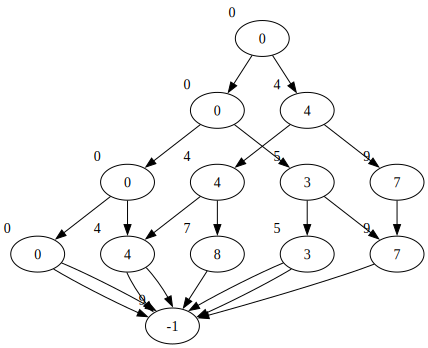

In [25]:
display_dd(dd)

## Reducing an exact DD

One of the key ideas from DDs is that very often, a DD can be compressed / reduced by merging nodes 
that 
- do not have identical (top-down) states
- but are nonetheless **equivalent** in the sense that they have the same *completions*, that is, the same set of partial solutions until the end (the solution sets of their tail subproblems are identical)

This type of equivalence can be identified by an upward-pass starting from the bottom layer $N$ to layer $0$

- in each layer $k$, two nodes are equivalent (are in the same equivalence class) if 
  - they have the same set of feasible decisions 
  - these decisions have the same costs
  - the corresponding arcs point to the same set of nodes in the subsequent layer $k+1$
- for each equivalence class, merge all nodes in that class into a single node

**Attention:** The following implementation assumes that the decision costs are state-independent. If the decision costs (the arc costs) are state-dependent, then we need to add a check for identical costs, too

## Implementing the DD reduction

In [28]:
import keyboard
def reduce_exact_dd(dd, step_by_step_visualization=False):
    
    #proceed from the bottom (last layer) to the top
    k = len(dd.layers)-1
    while k > 0:
        
        # a dict with key: decisions and resulting nodes (forming an equivalence class)
        #       and value: list of states falling into that class
        eq_classes = {}
    
        #1. collect equivalence classes and states/nodes in each class
        for state in dd.layers[k]:
            
            out_arc_info = []
            
            for u,v,decision,data in dd.g.out_edges((k,state),keys=True, data=True):
                out_arc_info.append((decision,v,data["cost"]))
                
            eq_class = tuple(sorted(out_arc_info))
            
            if eq_class not in eq_classes:
                eq_classes[eq_class] = [state]                
            else:
                eq_classes[eq_class].append(state)
        
        # 2. merge all states in each class into a single node
        for eq_class, states in eq_classes.items():            
            while len(states) > 1:
                state_remove = states.pop()
                merge_nodes(dd, k, states[0], state_remove)
        
        if step_by_step_visualization:
            display_dd(dd)
            keyboard.read_key()
            
                    
        k=k-1

## Merging two nodes

In [27]:
def merge_nodes(dd, layer_index, state_orig, state_remove):
    
    node_orig = (layer_index, state_orig)
    node_remove = (layer_index, state_remove)
    
    layer = dd.layers[layer_index]

    

    # 1. Keep the best distance to from the source
    if better(dd.g.nodes[node_remove]["best_dist"], dd.g.nodes[node_orig]["best_dist"], dd.direction):        
        (u,v,d) = dd.g.nodes[node_remove]["best_in_edge"]
        dd.g.nodes[node_orig]["best_in_edge"] = (u,node_orig,d)
        dd.g.nodes[node_orig]["best_dist"] = dd.g.nodes[node_remove]["best_dist"]

    
    # update best stuff
    
    for u, v, decision,data in dd.g.out_edges(node_remove, keys=True, data=True):
        if dd.g.nodes[v]["best_in_edge"] == (u,v,decision):
            dd.g.nodes[v]["best_in_edge"] = (node_orig, decision, v)
            

    # 3. redirect the in-arcs from the removed node to the node to be kept
    
    arcs_to_add = []
    for u,v,decision,data in dd.g.in_edges(node_remove, keys = True, data=True):
        arcs_to_add.append((u,node_orig, decision, data))
                           
    dd.g.remove_node(node_remove)
    layer.remove(state_remove)
    
    dd.g.add_edges_from(arcs_to_add)


## Trying it  out

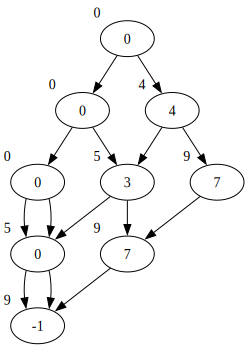

reduced nodes 9


In [29]:
reduce_exact_dd(dd, True)

print ("reduced nodes", get_number_of_nodes(dd))



..some sanity checks

In [30]:
get_best_objective (dd)

9

In [31]:
get_best_path(dd)[1][:10]

[np.int64(1), np.int64(1), np.int64(0), np.int64(0)]

### A Larger KP instance

In [32]:
dd = build_exact_dd(dp_kp, kp_instance, 0, 0,-1)

print(get_number_of_nodes(dd))

reduce_exact_dd(dd)

print(get_number_of_nodes(dd))

80725
19957


## Restricted Decision Diagrams

- building an exact decision diagram is often not practical since it may have an exponential size
- also, the reduction requires building the exact DD beforehand
- the idea of restricted DDs is to limit the size of the DD (more precisely, the width `maxWidth` of its layers) by removing states from each layer until the maximum width is respected
- of course, this introduces an approximation, that is, the solution is no longer guaranteed to be optimal


## Building a restricted DD top-down in Python

In [87]:
def build_restricted_dd(dp, instance, start_layer, start_state, sink_state, max_width,  sort_key_function=None):
    
    dd = DecisionDiagram(instance.N+1, start_layer, start_state, sink_state, dp.direction)  
    
    sort_key_function = get_sort_key_function_best_distance(dp)
    
    state = start_state
    total_cost = 0    
    
    for k in range(start_layer,instance.N):

        for state in dd.layers[k]:
            decisions = dp.feasible_decisions(instance, k, state)
            
            for decision in decisions:
                if k < instance.N -1:
                    next_state = dp.transition_function(instance,k,state, decision)
                else:
                    next_state = -1
                
                add_transition_dd(dd, k, state, decision, next_state, dp.cost_function(instance, k, state, decision)) 
                
         # remove_nodes until max_width is reached
        remove_until_max_width(dd, k+1,max_width, sort_key_function)       

    return dd

## Removing all nodes in a layer until maximum width

In [65]:
def remove_until_max_width(dd, layer_index, max_width, sort_key_function):

    if len(dd.layers[layer_index]) <= max_width:
        if dd.last_exact_layer == layer_index -1: 
            dd.last_exact_layer = layer_index
        return

    states_data = [(state, dd.g.nodes[(layer_index, state)]) for state in dd.layers[layer_index]]
    sorted_states = sorted(states_data, key=sort_key_function)
    
  
    for state, data in sorted_states[max_width:]:
        dd.layers[layer_index].remove(state) 
        dd.g.remove_node((layer_index,state))

## Some standard sort function

In [47]:
def sort_key_max_distance(state_data):
    return state_data[1]["best_dist"] * -1

In [46]:
def sort_key_min_distance(state_data):
    return state_data[1]["best_dist"] 

In [45]:
def get_sort_key_function_best_distance(dp):
    
    if dp.direction == 'max':
        return sort_key_max_distance
    else:
        return sort_key_min_distance

In [81]:
dd = build_restricted_dd(dp_kp, kp_instance, 0, 0,-1, 25)

DP(feasible_decisions=CPUDispatcher(<function feasible_decisions_kp at 0x00000204567A2A20>), transition_function=CPUDispatcher(<function transition_function_kp at 0x000002045BE3E7A0>), cost_function=CPUDispatcher(<function cost_function_kp at 0x000002045C14DF80>), direction='max')

In [82]:
get_best_objective (dd)

9147

## Task: Other sort functions

**Try out other sort functions!**
- using min distance instead of max distance for the KP#
- write your own function!

## Relaxed Decision Diagrams

- restricted DDs have a **limited size**, represent a **subset** of all feasible solutions of a DP, and thus give us an approximate feasible solution

- relaxed DDs have a **limited size**, represent a **superset** of all feasible solutions of a DP, and thus give us an upper (lower) bound in case of a maximization (minimization) problem
    - how can that work?

    
**Key idea:** By merging nodes that are not equivalent!
- to obtain a proper relaxation (to make sure that we have a superset of all feasible solutions, we apply a so-called **merge operation** $\oplus$ that makes sure that 
    - the solutions (paths to the terminal) starting from the merged state $s' = s_1 \oplus s_2$  form a superset of the union of the solutions (paths to the terminal) starting from $s_1$ and $s_2$
    - and that the best objective value starting from $s_1 \oplus s_2$ is at least as good as the 
- in simplified terms, $\oplus$ is chosen in a way that $s_1 \oplus s_2$ is less restrictive that both $s_1$ and $s_2$

## Top-down compilation of relaxed DDs: Python implementation

In [88]:
def build_relaxed_dd(dp, merge_function, instance, start_layer, start_state, sink_state, max_width, sort_key_function=get_sort_key_function_best_distance):
    
    dd = DecisionDiagram(instance.N+1, start_layer, start_state, sink_state)
    
    sort_key_function = get_sort_key_function_best_distance(dp)
    
    state = start_state
    total_cost = 0
    
    
    for k in range(start_layer,instance.N):
       
        for state in dd.layers[k]:
            decisions = dp.feasible_decisions(instance, k, state)
            
            for decision in decisions:
                if k < instance.N -1:
                    next_state = dp.transition_function(instance,k,state, decision)
                else:
                    next_state = -1
                
                add_transition_dd(dd, k, state, decision, next_state, dp.cost_function(instance, k, state, decision))
        

        merge_until_max_width(dd, merge_function, k+1, max_width, sort_key_function)
        

    return dd



## Merge until the maximum is reached

In [84]:
 def merge_until_max_width(dd, merge_function, layer_index, max_width, sort_key_function):
        
        layer = dd.layers[layer_index]
        prev_layer = dd.layers[layer_index-1]
        
        if len(layer) <= max_width:
            if dd.last_exact_layer == layer_index -1: 
                dd.last_exact_layer = layer_index
            return
        
        # 1. sort the nodes, return  a list of tuples  
        
        states_data = [(state, dd.g.nodes[(layer_index, state)]) for state in dd.layers[layer_index]]
        sorted_states = sorted(states_data, key=sort_key_function)
    
  
        
        # 2. update the set
        dd.layers[layer_index] = set(state for state, data in sorted_states[0:max_width-1])
        
        
        # 3. merge the remaining states into a single (relaxed) node
        
        # begin with the first state
        state, data = sorted_states[max_width-1]
        in_edges = [e for e in dd.g.in_edges((layer_index, state), keys=True)] 
        best_dist = data["best_dist"]
        best_pred_dec = (data["best_in_edge"][0], data["best_in_edge"][2])
                                     
        
        # 3a: compute the merged and collect in-edges
        for state_next, data_next in sorted_states[max_width:]:    
            
            state = merge_function(state, state_next) # compute the merged state
            in_edges += [e for e in dd.g.in_edges((layer_index, state_next), keys=True)]
            
            if better(data_next["best_dist"], best_dist, dd.direction):
                best_dist = data_next["best_dist"]
                best_pred_dec = (data_next["best_in_edge"][0], data_next["best_in_edge"][2])
        

        # remove the old nodes
        for state_remove, data in sorted_states[max_width -1:]:
            dd.g.remove_node((layer_index, state_remove))
            
            
        # add the new node
        dd.layers[layer_index].add(state)
        best_in_edge = (best_pred_dec[0], state, best_pred_dec[1])
        dd.g.add_node((layer_index, state), best_dist=best_dist, best_in_edge = best_in_edge)
        
        for u, v, decision in in_edges:
            dd.g.add_edge(u,state, decision)
                                     
                                    

## Trying the whole procedure

In [93]:
dd = build_relaxed_dd(dp_kp, min, kp_instance_tiny, 0, 0, -1, 2)


print ("dist", get_best_objective(dd), "nodes", get_number_of_nodes(dd))



dist 10 nodes 9


## Task: Other sort functions

**Try out other sort functions!**
- using min distance instead of max distance for the KP#
- write your own function!

## DD-based Branch-and-Bound

- for many problems, building the full exact DD is not feasible within an acceptable amount of time
- limited-size restricted and relaxed DDs (only) provide bounds
- however, they can be used in a DD-specific branch-and-bound scheme!
- that scheme was used to successfully solve a number of combinatorial optimization problems, in some cases achieving state-of-the-art performance
- the scheme is highly parallelizable

## DD-based Branch-and-Bound: Key ideas

**Key idea I: Branching on nodes in exact cutsets**

- in every relaxed (and restricted) DD, there are some nodes that are exact
- then, in a relaxed DD, we can identify so-called **exact cutsets:**
  - a **cutset** is a subset of nodes such that all source-terminal paths pass through at least one node in that subset
  - a cutset is called **exact** if all nodes represent exact states (not "relaxed" by the merge operation)
  
- now, instead of of increasing the width in layers after the exact cutset, the branch-and-bound starts building a "new" relaxed DD for the subproblem starting from each node in the cutset
- the nodes from the cutset are considered as "open nodes" which are processed one after the other
- when creating a "new" relaxed DD, we once again obtain an exact cutset that is then added to the set of open nodes

..one of the simplest ways to obtain an exact cutset is to use the "last exact layer", that is, the last layer in which no nodes needed to be removed / merged

**Key idea II: Bounding** 
- before building the relaxed DD for the current node, we build a restricted DD for the subproblem to (hopefully) obtain a new best feasible solution
- if the relaxed DD starting from the subproblem yields a solution that is worse than that "primal" solution, its exact cutset is not added to the set of open nodes

## DD-based Branch-and-Bound: Algorithm

In [65]:
from queue import PriorityQueue


def branch_and_bound_dd(dp, merge_function, instance, start_layer, start_state, sink_state, max_width):    
    
    best_feasible_obj = 0    
      
    factor_p_queue = 1
    if dp.direction == 'min':
        factor_p_queue = -1
    
    # initialise the set of open states (we use a priority queue here)
    # we store obj-function * factor as key for determining the priority, state and layer in the queue
    open_states = PriorityQueue()
    open_states.put((0, start_state, 0))
    
    number_of_open_states_considered = 1
    
    while open_states.qsize() > 0:
        number_of_open_states_considered += 1
        dist_to_state, state, layer = open_states.get() # get node from pqueue (and remove from queue)        
        dist_to_state = dist_to_state * factor_p_queue # "re-transform" if needed

        #solve restriction for the subproblem
        dd_restricted = build_restricted_dd(dp, instance, layer, state, sink_state, max_width)        
        restriction_obj = get_best_objective(dd_restricted)

        # see if we improved the best-known feasible solution
        if dist_to_state + restriction_obj > best_feasible_obj:            
            best_feasible_obj = dist_to_state + restriction_obj
           # print ("new best incumbent", best_feasible_obj )
            
        # if the subproblem is exact, no need to continue
        if dd_restricted.last_exact_layer == instance.N:
            continue
        
        #solve relaxation for the subproblem       
        dd_relaxed = build_relaxed_dd(dp, merge_function, instance, layer, state, sink_state, max_width)        
        relaxation_obj = get_best_objective(dd_relaxed) 
        
        # bounding: if cannot improve the best feasible solution, continue
        if dist_to_state + relaxation_obj <= best_feasible_obj:
            continue
    
        ## get last_exact_layer cutset and add to open nodes
        cutset = dd_relaxed.layers[dd_relaxed.last_exact_layer]    
        for state in  cutset:
            best_dist = dd_relaxed.g.nodes[(dd_relaxed.last_exact_layer, state)]["best_dist"]
            open_states.put((factor_p_queue * (dist_to_state + best_dist), state, dd_relaxed.last_exact_layer))

    print ("open states considered", number_of_open_states_considered)
    return best_feasible_obj
        
        

## Trying it out

In [66]:


#filename = "./../problems/knapsack/instances/knapPI_1_100_1000_1" # optimal value: 276457 
#values, weights, capacity  = read_knapsack_instance(filename)

kp_instance = KPInstance(values, weights,capacity,len(values))
filename = "./../problems/knapsack/instances/knapPI_1_100_1000_1"
kp_instance = read_kp_instance(filename)

N = 20
kp_instance_small = KPInstance(kp_instance.values[:N], kp_instance.weights[:N],kp_instance.capacity,  N)

In [67]:
%%time
branch_and_bound_dd(dp_kp, min, kp_instance_small, 0, 0, -1, 100)

open states considered 570
CPU times: total: 3.36 s
Wall time: 3.36 s


9147

In [68]:
%%time
dd = build_exact_dd(dp_kp, kp_instance_small, 0, 0,-1)
print("Size of exact DD:", get_number_of_nodes(dd))
get_best_objective(dd)

Size of exact DD: 8660
CPU times: total: 344 ms
Wall time: 334 ms


9147